# Predicting political affiliation from Twitter metadata ##

## Introduction

Predicting political affiliation based on Twitter data is a challenging problem that traditionally has been approached in two ways:

- __Parsing text__ of individuals' tweets to look for keywords
- Analyzing __metadata__ (followers, followees, etc.)

Pennacchiotti and Popescu established in [2010](http://www.aaai.org/ocs/index.php/ICWSM/ICWSM11/paper/viewFile/2886/3262) that the latter approach leads to higher accuracy results. Specifically, using only friends (i.e., who individual users follow on Twitter) can generate ~85% accuracy in predicting political affiliation, whereas text parsing coupled with a relatively sophisticated DLDA model does approximately 10 points worse.

Here, we use a small set of well-known politicians and celebrities to divide users along ideological lines. We then learn four different machine learning models (random forest, logistic regression, k-nearest neighbors with k=5, k-nearest neighbors with k=10) to classify users based on affiliation. The final model achieves an accuracy of __~90%__ in predicting a *proxy* for political affiliation. Predicting true political affiliation is likely harder, and the 90% accuracy would likely decrease by between 5-15% if we tested the model on a better indicator of political affiliation.

## Data gathering and cleaning

In [9]:
# Standard imports
import tweepy
import csv
import re
import operator 
from collections import Counter
from tweepy import OAuthHandler
import sys
import time
import urllib2
import pandas as pd
import numpy as np

In [209]:
# Retrieve consumer secret saved locally
import json
with open('../config.json') as data_file:    
    secret_data = json.load(data_file)
    consumer_secret = str(secret_data[0]['consumer_secret'])

# Tweepy OAuth 
consumer_key = "BVfNGMa15W5bKm2iRZHqLmNTx"
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
access_token = "52306095-Rr9ONTH5ZKbAcKDFj8h8AvsBPuH0x2qiRPWg7oaI6"
access_token_secret = "vtZm8fNE2VxxCVhQCkrUMPeKxggdbMZFPSPy2LXctHIGm"
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
 
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Next, we're going to build a small dataset of 250 Democrats and 250 Republicans by searching for users who tweeted __"#ImWithHer"__ and __"#MAGA."__

Note that this does not generate ideal ground truth test labels, as tweeting these slogans is not necessarily the same as being a Democrat/Republican.

We would ideally like some sort of self-reporting tool to generate our test set (i.e., find users who self-identified as Democrats and Republicans), although, unfortunately, the popular tools for self-identification (e.g., www.wefollow.com) have been shut down over the last several years. A potential next step here would be to use Amazon Mechanical Turk to hand-label ~1000 users and build a more robust test set.

In [211]:
democrats_iterator = tweepy.Cursor(api.search_users,
                           q="#ImWithHer",
                           count=1000,
                           result_type="recent",
                           include_entities=True,
                           lang="en").items(250)

republicans_iterator = tweepy.Cursor(api.search_users,
                           q="#MAGA",
                           count=1000,
                           result_type="recent",
                           include_entities=True,
                           lang="en").items(250)

democrat_ids = []
republican_ids = []
democrat_names = []
republican_names = []

count = 0
for d in democrats_iterator:
    count += 1
    if count % 100 == 0:
        print "Democrat {0}".format(count)
    democrat_ids.append(d.id)
    democrat_names.append(d.screen_name)

count = 0
for r in republicans_iterator:
    count += 1
    if count % 100 == 0:
        print "Republican {0}".format(count)
    republican_ids.append(r.id)
    republican_names.append(r.screen_name)

Democrat 100
Democrat 200
Republican 100
Republican 200


We then set out a standard list of __'followees'__, or politicians and celebrities we believe should strongly divide individuals along ideological lines. We can use the Twitter API to determine, for each (follower, followee) pair, whether there is a relationship or not (binary indicator of 1 or 0). The full set of followees we include here is:

- Hillary Clinton
- Donald Trump
- Ted Cruz
- Elizabeth Warren
- Bernie Sanders
- Mike Pence
- Sean Hannity

In [6]:
followees = ['HillaryClinton', 
             'realDonaldTrump', 
             'tedcruz', 
             'elizabethforma', 
             'SenSanders', 
             'mike_pence',
             'seanhannity']
id_dict = {}
for followee in followees:
    results = api.get_user(followee)
    id_dict[results.id] = results.screen_name

In [214]:
# Create pandas dataframe and prepopulate with dummy values

user_ids = pd.Series(democrat_ids + republican_ids)
user_names = pd.Series(democrat_names + republican_names)
dems = np.ones(len(democrat_ids))
is_democrat = pd.Series(np.append(dems, np.zeros(len(republican_ids))))

df = pd.DataFrame({ 'user_id' : user_ids,
                    'user_names' : user_names,
                    'is_democrat' : is_democrat,
                    followees[0] : None,
                    followees[1] : None,
                    followees[2] : None,
                    followees[3] : None,
                    followees[4] : None,
                    followees[5] : None,
                    followees[6] : None
                  })

# Populate (follower, followee) pairs in the dataframe. Since we hit the rate limit 
# after 180 calls, this code takes ~5 hours to run.

for followee_id in id_dict:
    followee = id_dict[followee_id]
    print("Retrieving {0} data".format(followee))
    count = 0
    for user_id in user_ids:
        try:
            friendship = api.show_friendship(source_id=user_id, target_id=followee_id)
        except RateLimitError:
            print("Sleeping for 15 minutes...")
            time.sleep(60*15)
        follows_politician = friendship[1].followed_by
        df.loc[df.user_id == user_id, followee] = follows_politician
        count += 1
        if (count % 20 == 0):
            print("Processing follower number {0}".format(count))

Retrieving realDonaldTrump data
Processing follower number 20
Processing follower number 40
Processing follower number 60
Processing follower number 80
Processing follower number 100
Processing follower number 120
Processing follower number 140
Processing follower number 160
Processing follower number 180
Rate limit reached. Sleeping for: 862
Processing follower number 200
Processing follower number 220
Processing follower number 240
Processing follower number 260
Processing follower number 280
Processing follower number 300
Processing follower number 320
Processing follower number 340
Processing follower number 360
Rate limit reached. Sleeping for: 861
Processing follower number 380
Processing follower number 400
Processing follower number 420
Processing follower number 440
Processing follower number 460
Processing follower number 480
Processing follower number 500
Retrieving SenSanders data
Processing follower number 20
Processing follower number 40
Rate limit reached. Sleeping for: 

In [215]:
# Save data file
df.to_csv("saved_twitter_user_data_2.csv")

## Prediction

Now we can try some real machine learning! We're going to test out four different classifiers to see which one has the highest accuracy on the dataset. 

In [7]:
import sklearn
import sklearn.ensemble as ensemble
import sklearn.linear_model as linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation
from sklearn import metrics
import copy
import pandas as pd

df = pd.read_csv("saved_twitter_user_data_1.csv")

classifiers = [(ensemble.RandomForestClassifier(), "random forest"),
               (linear_model.LogisticRegression(C=1.0), "logistic regression"), 
               (KNeighborsClassifier(n_neighbors=5), "kNN, k = 5"),
               (KNeighborsClassifier(n_neighbors=5), "kNN, k = 10")]
               
followee_sets = [['mike_pence', 'seanhannity', 'tedcruz'], 
                 ['SenSanders', 'elizabethforma'], 
                 ['mike_pence', 'elizabethforma', 'SenSanders'], 
                 ['tedcruz','SenSanders', 'seanhannity'], 
                 ['realDonaldTrump', 'HillaryClinton'], 
                 followees] # this last set is all followees
accuracies = [[], [], [], []]

for i, (classifier, _) in enumerate(classifiers):
    classifier_accuracies = []
    for feature_followees in followee_sets:
        X = df.loc[:,feature_followees].as_matrix()
        y = df.loc[:, 'is_democrat']
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0, random_state=8)
        classifier.fit(X_train, y_train)
        predictions = classifier.predict(X_train)
        accuracy = metrics.accuracy_score(predictions, y_train)
        classifier_accuracies.append(accuracy)
    accuracies[i] = classifier_accuracies

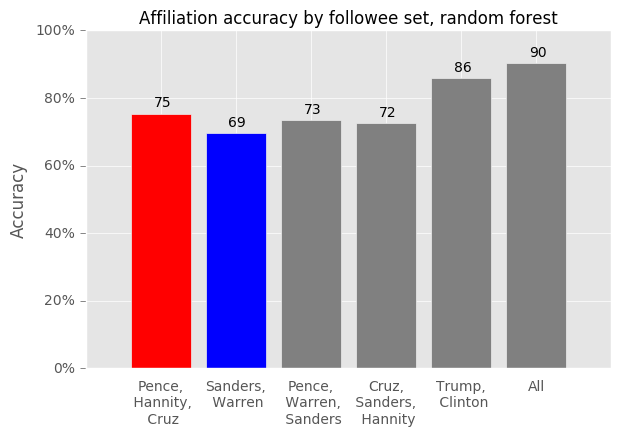

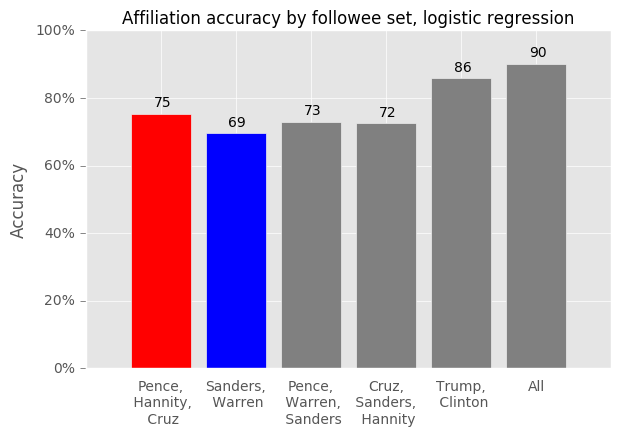

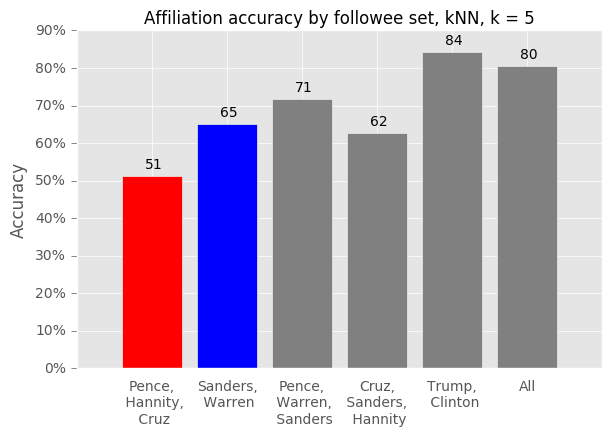

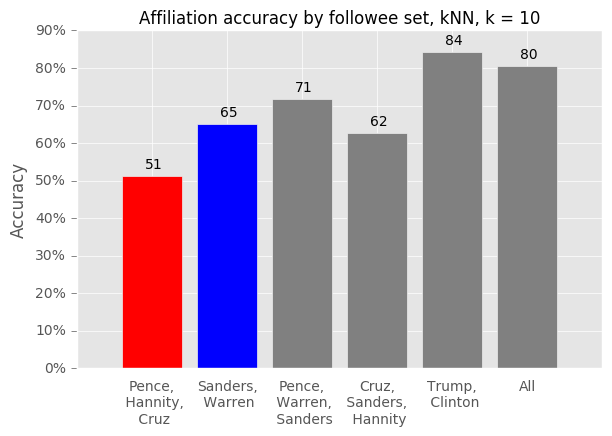

In [12]:
# Plotting

from matplotlib import pyplot as plt
plt.style.use('ggplot')

def plot_accuracies(accuracies, classifier, figure):
    plt.figure(figure)
    fig, ax = plt.subplots()
    colors = ['red', 'blue', 'gray', 'gray', 'gray', 'gray']
    fig.tight_layout()

    plt.bar(np.arange(6), accuracies, align="center", color=colors)
    y_ticks = ax.get_yticks()
    percentages = [str(int(y * 100)) + "%" for y in y_ticks]

    ax.set_xticks([0, 1, 2, 3, 4, 5])
    ax.set_xticklabels(["Pence,\n Hannity,\n Cruz", 
                        "Sanders,\n Warren", 
                        "Pence,\n Warren,\n Sanders",
                        "Cruz,\n Sanders, \n Hannity",
                        "Trump,\n Clinton", 
                        "All"])
    ax.set_yticklabels(percentages)
    ax.set_ylabel("Accuracy")
    ax.set_title("Affiliation accuracy by followee set, {0}".format(classifier), fontsize=12)

    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on') # labels along the bottom edge are off

    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='on',         # ticks along the bottom edge are off
        right='off')       # ticks along the top edge are off
    
    for i, v in enumerate(accuracies):
        plt.text(i - 0.1, v + 0.02, str(int(v * 100)), color='black')

    plt.show()

# accuracies
for i in range(len(classifiers)):
    plot_accuracies(accuracies[i], classifiers[i][1], i)

## Discussion

Unsurprisingly, kNN performs slightly worse than the random forest and logistic regression models. The latter two models are nearly identical in their performance.

### A few notes:

- The gray bars represent followee sets with a mix of political affiliations. Excluding Trump/Clinton, classifiers trained on these followee sets do not perform substantially better than classifiers trained on Democrat-only or Republican-only followee sets
- Classifiers trained only on Trump and Clinton as followees perform quite well (at 86%). This is unsurprising given the outcomes we are trying to learn (tweeting #ImWithHer and #MAGA)
- The very best classifiers are those that include all of the politicians, although we get only a 4 percentage point kick from adding in other followees on top of Trump and Clinton

### Some potential next steps:

- Find better ground truth labels (i.e., hand-labeled affiliation instead of affiliation inferred based on hashtags)
- Train on a larger training set
- Determine how to scale this prediction methodology in spite of Twitter rate limits